<div style="float:left">
    <h1 style="width:450px">Live Coding 7: NLTK and Friends</h1>
    <h2 style="width:450px">Working with Textual Data!</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

## Preamble

This practical has been written using `nltk`, but would be _relatively_ easy to rework using `spacy` _except_ that you'd have to first load the requisite models:
```python
import spacy
nlp = spacy.load("en_core_web_sm") # `...web_md` and `...web_lg` are also options
```
You can [read about the models](https://spacy.io/models/en), and note that they are also [available in other languages](https://spacy.io/usage/models).

#### Required Modules

Notice that here we need rather a larger number of modules and functions!

In [ ]:
import os
import pandas as pd
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup #web scraping 

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
from sklearn.preprocessing import OneHotEncoder # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
import nltk
import spacy
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
#from nltk.tokenize.stanford import StanfordTokenizer

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

from nltk import ngrams, FreqDist

lemmatizer = WordNetLemmatizer()
tokenizer = ToktokTokenizer()

This next is just a small utility function that allows us to output Markdown (like this cell) instead of plain text:

In [ ]:
from IPython.display import display_markdown

def as_markdown(head='', body='Some body text'):
    if head != '':
        display_markdown(f"##### {head}\n\n>{body}\n", raw=True)
    else:
        display_markdown(f">{body}\n", raw=True)

#### Loading and Tidying the Data

Let's only load a subset of the columns--we don't need all 70+ fields, just a few that might be useful for textual analysis:

In [5]:
cols = ['id','listing_url','name','price','description','host_id','host_about','host_listings_count',
        'latitude','longitude','property_type','room_type','accommodates',
        'bathrooms','bathrooms_text','bedrooms','beds','amenities',]
df = pd.read_csv(os.path.join('data','raw','2020-08-24-listings.csv.gz'), usecols=cols, low_memory=False)
df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)

/tmp/ipykernel_268/969365004.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['price'] = df.price.str.replace('$','').str.replace(',','').astype(float)


In [6]:
df.drop(df[((df.latitude.isna())|(df.longitude.isna()))].index, axis=0, inplace=True)
df.drop(df[((df.latitude < 40)|(df.longitude > 1))].index, axis=0, inplace=True)
print(df.shape)

(74184, 18)


#### Remove NA Values from Text Fields

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: I would be very wary of doing this in a 'proper' application, but to make our lives easier, we're going to drop rows where one of these values is NaN _now_ so it will simplify the steps below. In reality, I would spend quite a bit more time investigating which values are NaN and why before simply dropping them.</div>

Anyway, drop all NaN values:

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74184 entries, 0 to 74187
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   74184 non-null  float64
 1   listing_url          74184 non-null  object 
 2   name                 74163 non-null  object 
 3   description          71325 non-null  object 
 4   host_id              74184 non-null  float64
 5   host_about           42490 non-null  object 
 6   host_listings_count  74175 non-null  float64
 7   latitude             74184 non-null  float64
 8   longitude            74184 non-null  float64
 9   property_type        74184 non-null  object 
 10  room_type            74184 non-null  object 
 11  accommodates         74184 non-null  float64
 12  bathrooms            0 non-null      float64
 13  bathrooms_text       74029 non-null  object 
 14  bedrooms             69592 non-null  object 
 15  beds                 73197 non-null 

In [8]:
df.drop('bathrooms',axis=1,inplace=True)

In [9]:
df.isna().sum()

id                         0
listing_url                0
name                      21
description             2859
host_id                    0
host_about             31694
host_listings_count        9
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bathrooms_text           155
bedrooms                4592
beds                     987
amenities                  0
price                      0
dtype: int64

In [10]:
df.drop(index=df[df.name.isna()|df.description.isna()|df.bathrooms_text.isna()|df.beds.isna()|df.bedrooms.isna()|df.host_about.isna()].index, axis = 0, inplace=True)
print(df.shape)

(38762, 17)


Notice the scale of that change: according to my queries, we had 74,184 records after dropping rows that were unmappable, but for rows that are missing information about the description, amenities, and host, we've lost nearly half! 

#### Convert to GeoPandas

Read in the Boroughs GeoPackage so that we have a bit more geography here. I'm doing this from GitHub but you could change the URL to be a local file instead if you've already downloaded the file and don't want to download it every time you run this script. We then reproject the InsideAirbnb data to BNG and plot using price as a colormap.

In [11]:
boros = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Boroughs.gpkg?raw=true')

/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [12]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude, crs='epsg:4326'))
gdf = gdf.to_crs('epsg:27700')

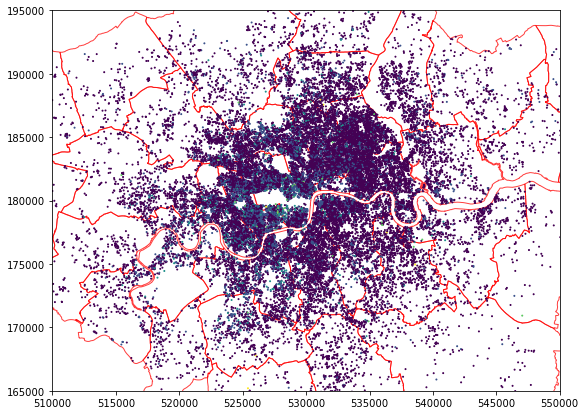

In [13]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
# Why would we use FJ_Sampled here?
gdf.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

## Previewing Textual Data

It's helpful to have a sense of what these data look like before trying to do something with them. You can also change the amount of preview text provided using the pandas options:
```python
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=100    # What do we want to set it to?
```

<div style="border: dotted 1px green; padding: 10px; margin: 5px; background-color: rgb(249,255,249);"><i>Hint</i>: In a full text-mining application I would spend a lot more time on this stage: sampling, looking at descriptions in full, performing my analysis (the rest of the steps) and then coming back with a deeper understanding of the data to make further changes to the analysis.</div>

In [14]:
print(pd.options.display.max_colwidth) # What's this currently set to?
pd.options.display.max_colwidth=150   # None = no maximum column width (you probably don't want to leave it at this)

50


#### Description

In [15]:
# Technically, the `isna` is no longer needed, but I left it here for 
# illustrative purposes about how I went about researching what was in
# the data before filtering it out in the cell block up above
gdf[~gdf.description.isna()].description.sample(8, random_state=42)

17408    Situated in Zone 2<br /><br />I am offering my spacious double room with the use of a bathroom in my home, only a stones throw away from the stati...
67971    *** Travel ***<br />The flat is a 10-12 minute walk from Oval station on the Northern line. It's also within walking distance to Stockwell on the ...
49110    VERY CENTRAL LOCATION..CLOSE TO THE HEART OF LONDON <br />BRIGHT SPACIOUS BEAUTIFULLY DECORATED 1 BEDROOM FLAT.<br />MODERN NEWLY FURNISHED AND DE...
8184     Full 1 bedroom flat for rent<br /><br /><b>The space</b><br />This spacious one bedroom apartment is located in a well-maintained 1970's building ...
1939     -Covent Garden/Somerset House <br />- Mayfair, St. James’s, Leicester Square, Soho, Thames, Trafalgar Square, Thames, Buckingham Palace all within...
39158    Modern flat that you will love to stay in<br />2 double bed apartment in ZONE 1, <br /><br />10mins walk to:<br />London Bridge / Tower of London ...
34224    Wonderful double bedroom to stay for 

#### About the Host

In [16]:
gdf.host_about.sample(8, random_state=42)

17408                                                              ✈ Ailsa Vanessa Tapping ✈\r\n\r\n☼ Human Being / TV and Film Producer / Sunseeker ☼\r\n\r\n
67971    I am a 28-year-old Investment Banker from London. I've lived here all my life so I can give you plenty of insight into the cool things to do in th...
49110    I would like to welcome you to London and if you have any more questions please feel free to contact me.\r\n\r\nI have been described by my previo...
8184     I'm a London based Commercial Interior Designer. I rent out my home when I'm away so other people can enjoy it and the Islington neighbourhood. I ...
1939                                                                                                                             free mind and good vibrations
39158    As a host, I make sure that your apartment is fully equipped so you have everything you would need so you don't miss your own home.   \r\nI manage...
34224                                         

#### Amenities

We don't do anything with this column across the remainder of the notebook, but you'll note that this is a list in the form of a string so you would need to 'deserialise' it using either regular expressions/str.split() _or_ `eval` (more on that [here](https://www.programiz.com/python-programming/methods/built-in/eval)) which is a seriously dangerous method if you don't know what you're doing and/or don't do any checking of the input. To my mind this would be a good candidate for One-Hot encoding after doing a little investigation of the frequency-of-use (_ie_ do you want to dedicate an entire column in an 80k data frame to an amenity that only occurs in 2 listings?).

In [17]:
gdf.amenities.sample(8, random_state=42)

17408    ["Wifi", "Kitchen", "Smoke alarm", "Dryer", "Lock on bedroom door", "Hangers", "Carbon monoxide alarm", "Washer", "Shampoo", "Free parking on prem...
67971    ["Wifi", "Iron", "Kitchen", "Smoke alarm", "Dryer", "Private living room", "Essentials", "Hangers", "TV", "Washer", "Carbon monoxide alarm", "Heat...
49110    ["Paid parking off premises", "Refrigerator", "Hangers", "TV", "Bed linens", "Iron", "Hot water", "Kitchen", "First aid kit", "Smoke alarm", "Carb...
8184                                                          ["Wifi", "Kitchen", "Essentials", "Hangers", "TV", "Washer", "Shampoo", "Hair dryer", "Heating"]
1939     ["Refrigerator", "Dryer", "Hangers", "TV", "Pack \u2019n Play/travel crib", "Bed linens", "Shower gel", "Iron", "Hot water", "Kitchen", "First aid...
39158    ["Elevator", "Hot water", "Gym", "Lockbox", "Extra pillows and blankets", "High chair", "Shampoo", "Smoke alarm", "Wifi", "Fire extinguisher", "Fi...
34224    ["Hot water", "Hair dryer", "Paid par

## Using Regular Expressions

There is a _lot_ that can be done with Regular Expressions to identify relevant records in textual data and we're going to use this as a starting point for the rest of the analysis. I would normally consider the regexes here a 'first pass' at the data, but would look very carefully at the output of the TF/IDF vectorizer, Count vectorizer, and LDA to see if I could improve my regexes for further cycles of analysis... the main gain there is that regexes are _much_ faster than using the full NLP (Natural Language Processing) pipeline on the _full_ data set each time. As an alternative, you could develop the pipeline using a random subsample of the data and then process the remaining records sequentially -- in this context there is no justification for doing that, but with a larger corpus it might make sense.

#### Luxury Accommodation

I would encourage you to consider what other words might help to signal 'luxury'... perhaps words like 'stunning' or 'prestigious'? Could you add those to the regex?

In [18]:
gdf[gdf.description.str.contains(r'luxur(?:y|ious)', 
                                 regex=True, 
                                 flags=re.IGNORECASE)].description.sample(15, random_state=42)

# also works without ?:   ???
# matches 0 or 1 occurrence of preceding expression 

958      This is a highest specification, luxury and fully equipped one bedroom designer apartment with all domestic appliances.  The apartment sleeps up t...
17686    This superb two-bed/one-bath apartment boasts a two-level open plan living space, handmade King beds and mattresses and great en-suite facilities....
51156    This is a Luxury compact 1 bedroom apartment in tranquil Little Venice.  It is moment’s away from the canal, and very close to transportation.<br ...
73911    In Luxury Nell Gwynn House Fully equipped at Famous building and top location , airy spacious living room <br />Min 3 months  booking up to longer...
12277    Luxury centrally located two double bedroom flat, with open plan reception / kitchen, and two full bathrooms on the second floor of a Georgian con...
28687    Private double bedroom with shared use of a modern kitchen, living room and main bathroom. Guests get their own private toilet and full access to,...
62274    We are delighted to offer this amazin

Assign it to a new data frame called `lux`:

In [19]:
lux = gdf[gdf.description.str.contains(r'luxur(?:y|ious)',
                                       regex=True, 
                                       flags=re.IGNORECASE)].copy()
print(lux.shape)


(3076, 18)


And plot:

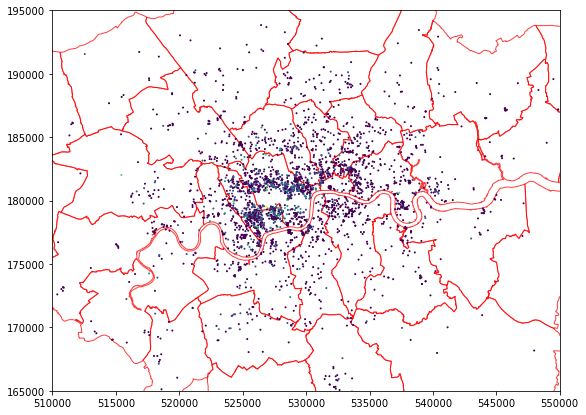

In [20]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
ax = lux.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

#### Budget Accommodation

What words can you think of that might help you to spot affordable and budget accommodation? Start with just a couple of words and then I would encourage you to consider what _other_ words might help to signal 'affordability'... perhaps words like 'cosy' or 'charming' and then think about how you could you add those to the regex?

In [21]:
gdf[gdf.description.str.contains(r'(?:affordable|budget|cheap)', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)
     

255      Single room with single bed,  armchair, desk and chair and en suite shower room with wc and basin. Room is also supplied with a kettle, a fridge a...
65488    We like to welcome guest to this amazing property where we have individual rooms available to all types of travellers who wants to be thick of eve...
9328     Bright double room in Hoxton. Very well located with only a 5 Minute walk to Old Street station and 5 minute walk to Hoxton Overground. 10 minutes...
65050    Spacious open plan room containing full kitchen & bed with fresh linen, towels & free breakfast. 2-min walk from shopping (Oxford Street & Tottenh...
60687    Tucked inside 3 buildings in the sprawling 54-acre Holland Park, an easy 8-minute jaunt to the Holland Park tube station – and easily walkable to ...
24749    A clean and neat one bedroom apartment located in a Central Soho location, one minute from Oxford Street and seconds to Great Marlborough Street, ...
27397    DO NOT BOOK if you have not experienc

In [22]:
aff = gdf[gdf.description.str.contains(r'(?:affordable|budget|cheap)', regex=True, flags=re.IGNORECASE)].copy()
print(aff.shape)

(532, 18)


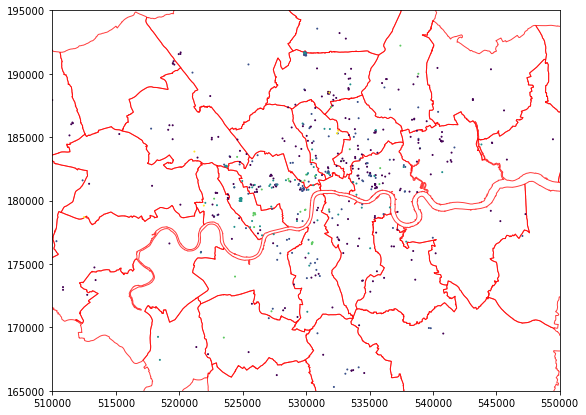

In [23]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
ax = aff.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

#### Near Greenspace

Now see if you can work out a regular expression to find accommodation that emphasises accessibility to greenspace as part of the description? One thing you'll need to tackle is that many listings seem to say something about _parking_ and you wouldn't want those be returned as part of a regex looking for _parks_.

In [24]:
# ? how to find green  space

In [25]:
#print(pd.options.display.max_colwidth)
#pd.options.display.max_colwidth=100
gdf[gdf.description.str.contains(r' parks?\b', regex=True, flags=re.IGNORECASE)].description.sample(15, random_state=42)
pd.options.display.max_colwidth=30

In [26]:
green = gdf[gdf.description.str.contains(r' parks?\b', regex=True, flags=re.IGNORECASE)].copy()
print(green.shape)

(10484, 18)


In [27]:
parks = gpd.read_file('https://github.com/jreades/i2p/blob/master/data/src/Greenspace.gpkg?raw=true')



/opt/conda/envs/sds2021/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


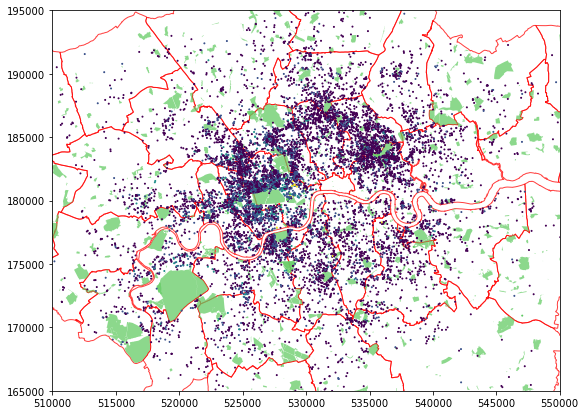

In [28]:
ax = boros.plot(figsize=(10,7), edgecolor='red', facecolor='none', linewidth=1, alpha=0.75)
parks.plot(edgecolor='none', facecolor=(0.4, 0.8, 0.4, 0.75), ax=ax)
green.plot(markersize=1, column='price', cmap='viridis', scheme='Fisher_Jenks_Sampled', ax=ax)
ax.set_xlim([510000, 550000])
ax.set_ylim([165000, 195000]);

## Illustrative Text Cleaning

Now we're going to step through the _parts_ of the process that we apply to clean and transform text. We'll do this individually before using a function to apply them _all at once_.

In [29]:
from urllib.request import Request, urlopen
url ='https://www.ucl.ac.uk/bartlett/casa/about'
req = Request(url=url, headers={'User-Agent':"Mozilla/5.0"})  
the_html=urlopen(req).read()


In [30]:
the_html[-250:]

b'ookie_compliance_cookie_name = "";\n//--><!]]>\n</script>\n<script type="text/javascript" defer="defer" src="https://www.ucl.ac.uk/bartlett/casa/sites/all/modules/contrib/eu_cookie_compliance/js/eu_cookie_compliance.js?r313lf"></script>\n</body>\n</html>\n'

### Lower Case

We also do some basic filtering on empty lines and I'm going to cheat a little by extracting only the 'About Us' section of the document (you would use BS4 to do this normally):

In [31]:
lower = [x.lower() for x in the_html.decode("utf-8").split("\n") if not re.match("^\s*$", x)]


In [32]:
for l in lower[175:176]:
    as_markdown("Content", l)

##### Content

></div>casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.<p>we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live.</p><p>based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities.</p><p>casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities.</p><h2 class="heading">our vision</h2><p>casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation.</p><p>our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl.</p><p>our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense.</p><p>the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning.</p><h2 class="heading">location</h2><p>the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj. </p><p><a class="map-link map-link--0" href="//www.google.co.uk/maps/?z=15&amp;q=loc:51.521983,-0.1360091"><div class="map map--1">


### Removing HTML

In [33]:
cleaned = []
for l in lower[175:176]:
    # What is this regex doing? Maybe 'view source' the URL?
    tmp = re.sub(r'(\/[A-Za-z]+\d?|[A-Za-z]+ \/)>','\\1> ', l)
    soup = BeautifulSoup(tmp, "html.parser")
    # What is going on here?
    if not re.match(r'^\s*$',soup.get_text()):
        cleaned.append(soup.get_text())

In [34]:
for c in cleaned:
    as_markdown("Listing", c)

##### Listing

> casa was established in 1995 to lead the development of a science of cities drawing upon methods and ideas in modelling, sensing the urban environment, visualisation and computation.we seek to examine and offer solutions to the problems of resource efficiency and effective planning and governance shared by all cities. our vision is to play a central role in the science of smart cities – applying it to city planning, policy and architecture in the pursuit of making our cities better places to live. based in bloomsbury, london, casa is our living laboratory. as one of the world’s truly global metropolises there is nowhere more ideal than london for learning about the challenges confronting modern cities. casa has established a concentration of academics with a wide breadth of expertise from a range of disciplines, all with a common domain knowledge in cities. our vision casa's focus is to be at the forefront of what is one of the grand challenges of 21st century science: to build a science of cities from a multidisciplinary base, drawing on cutting edge methods, and ideas in modeling, complexity, visualisation and computation. our current mix of geographers, mathematicians, physicists, architects and computer scientists make casa a unique institute within ucl. our vision is to be central to this new science, the science of smart cities, and relate it to city planning, policy and architecture in its widest sense. the focus is on advancing the state of the art through research complemented by graduate study, teaching, consultancy and distance learning. location the ucl centre for advanced spatial analysis is located at 90 tottenham court road, london, w1t 4tj.  


### Punctuation

We want to clear out punctuation using a regex that takes advantage of the `[...]` syntax:

In [ ]:
for p in punkt:
    as_markdown("Listing", p)

### Stopword Removal

In [ ]:
from nltk.corpus import stopwords
stopword_list = set(stopwords.words('english'))
stopped = []
for p in punkt:
    stopped.append(' '.join([x for x in re.split(r'\s+', p) if x not in stopword_list]))

In [ ]:
for s in stopped:
    as_markdown("Listing", s)

### Lemmatisation vs Stemming

In [ ]:
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer 

In [ ]:
lemmatizer = WordNetLemmatizer()
print(lemmatizer.lemmatize('monkeys'))
print(lemmatizer.lemmatize('cities'))
print(lemmatizer.lemmatize('complexity'))
print(lemmatizer.lemmatize('Reades'))

In [ ]:
stemmer = PorterStemmer()
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

In [ ]:
stemmer = SnowballStemmer(language='english')
print(stemmer.stem('monkeys'))
print(stemmer.stem('cities'))
print(stemmer.stem('complexity'))
print(stemmer.stem('Reades'))

In [ ]:
lemmatizer = WordNetLemmatizer()
lemmas = []
for s in stopped:
    lemmas.append(' '.join([lemmatizer.lemmatize(x) for x in s.split(' ')]))

In [ ]:
for l in lemmas:
    as_markdown('Listing',l)

## Applying Normalisation

The above approach is fairly hard going since you need to loop through every list element applying these changes one at a time. Instead, we can use pandas `apply` method together with some code built on top of work by others to simplify this process even though it will still be processor-intensive.

#### Downloading the Custom Module

You will need to download _and_ unzip [this file](https://github.com/jreades/i2p/blob/master/practicals/textual.zip?raw=true) into the directory where this notebook is running (since the `import` will look for a directory named `textual` wherever this code is running. The custom module is not perfect, but it gets the job done... mostly.

#### Importing the Custom Module

Now let's import it.

In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
from textual import *

/home/jovyan/work/Documents/CASA/modules/fsds/i2p/textual/__init__.py:40: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if head is not '':
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [40]:
as_markdown('Normalised', normalise_document(the_html.decode('utf-8')))





#### Normalised

>bartlett centre advanced spatial analysis ucl university college london close ucl home prospective student current student staff give bartlett centre advanced spatial analysis home home people study research publication partnerships news event casa seminar series 2021 ucl home bartlett centre advanced spatial analysis ucl home bartlett centre advanced spatial analysis centre advanced spatial analysis casa interdisciplinary research institute focus science city within bartlett faculty build environment ucl casa establish 1995 lead development science city draw upon method idea modelling sense urban environment visualisation computation seek examine offer solution problem resource efficiency effective planning governance share city vision play central role science smart city apply city planning policy architecture pursuit make city well place live base bloomsbury london casa live laboratory one worl truly global metropolis nowhere ideal london learn challenge confront modern city casa establish concentration academic wide breadth expertise range discipline common domain knowledge city vision casas focus forefront one grand challenge 21st century science build science city multidisciplinary base draw cut edge method idea modeling complexity visualisation computation current mix geographer mathematician physicist architect computer scientist make casa unique institute within ucl vision central new science science smart city relate city planning policy architecture wide sense focus advance state art research complement graduate study teaching consultancy distance learning location ucl centre advanced spatial analysis locate tottenham court road london w1t 4tj view map contact address ucl centre advanced spatial analysis first floor tottenham court road london w1t 4tj telephone +44 3108 3877 student enquiry please contact mohammod hussain tel +44 3108 3327 enquiry please email casa ucl job vacancy casa list also follow twitter connect linkedin tweet casaucl ucl facility ucl faculty department library museum collection ucl bloomsbury theatre ucl shop ucl location map building ucl london ucl global ucl east connect ucl alumnus business medium relation job support university college london gower street london wc1e 6bt tel +44 7679 2000 copyright 2021 ucl disclaimer freedom information accessibility privacy cooky slavery statement contact


## Revenons à Nos Moutons

Now that you've seen how the steps are applied to a 'random' HTML document, let's get back to the problem at hand (revenons à nos moutons == let's get back to our sheep).

In [46]:
lux.description.apply(normalise_document)

74       perfect studio apartment s...
80       best view london far excee...
81       available 2018 floor openp...
87       lovely large two story hom...
95       amazing luxury apartment e...
                     ...              
74045    enjoy beauty london newly ...
74048    set top floor storey new b...
74056    welcome beautiful centrall...
74067    feel home wherever choose ...
74161    amaze marble arch double r...
Name: description, Length: 3076, dtype: object

In [ ]:
lux['description_norm'] = lux.description.??(??)

In [ ]:
aff['description_norm'] = aff.description.??(??)

In [ ]:
green['description_norm'] = green.description.??(??)

#### Full File

<div style="border: dotted 1px red; padding: 10px; margin: 5px; background-color: rgb(255,249,249);"><i>Warning</i>: This code can take <i>some time</i> to run, so <b>don't run this now</b> as we're just going to work with the subsets!</div>


You will get a warning about `"." looks like a filename, not markup` -- this looks a little scary, but is basically suggesting that we have a description that consists only of a '.'. 

In [ ]:
gdf['description_norm'] = ''
gdf['description_norm'] = gdf.description.apply(normalise_document)

In [ ]:
gdf.to_file(os.path.join('data','raw','2020-08-24-listings-with-nlp-subset.gpkg'))

/tmp/ipykernel_106/539007375.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(os.path.join('data','raw','2020-08-24-listings-with-nlp-subset.gpkg'))


## Feature Extraction

See useful tutorial [here](https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275). Although we shouldn't have any empty descriptions, by the time we've finished normalising the textual data we may have _created_ some empty values and we need to ensure that we don't accidentally pass a NaN to the vectorisers and frequency distribution functions.

In [ ]:
corpus = lux.description_norm.fillna(' ').values

In [ ]:
print(corpus[0:2])

#### Frequency Distributions

Regular expressions _again_! See, we use them all over the place. See if you can expand the regex to suppress all punctuation _and_ numbers. This is a metacharacter problem.

One new thing you'll see here is the `ngram`: ngrams are 'simply' pairs, or triplets, or quadruplets of words. You may come across the terms unigram (`ngram(1,1)`), bigram (`ngram(2,2)`), trigram (`ngram(3,3)`)... typically, you will rarely find anything beyond trigrams, and these present real issues for text2vec algorithms because the embedding for `geographical`, `information`, and `systems` is _not_ the same as for `geographical information systetms`.

In [ ]:
data = [x for x in ' '.join(corpus).split() if not re.match(r'[,.\-\(\)!\&0-9\;\:]', x)]

fcounts = dict()

for size in 1, 2, 3:
    fdist = FreqDist(ngrams(data, size))
    print(fdist)
    # If you only need one, note this: https://stackoverflow.com/questions/15145172/nltk-conditionalfreqdist-to-pandas-dataframe
    fcounts[size] = pd.DataFrame.from_dict({f'Ngram Size {size}': fdist})

In [ ]:
for dfs in fcounts.values():
    print(dfs.sort_values(by=dfs.columns.values[0], ascending=False).head(10))

#### Count Vectoriser

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,3))
vectorizer.fit(??)

Note all of the methods available to interrogate the transformer:

In [ ]:
dir(vectorizer)

Find the number associated with a word in the vocabulary:

In [ ]:
# Find the vocabulary mapping
print(vectorizer.vocabulary_['stratford'])

How many times does it occur in the original corpus:

In [ ]:
lux.description_norm.str.contains('stratford').sum()

Note the type of the transformed corpus:

In [ ]:
tcorpus = vectorizer.transform(corpus)
tcorpus # tcorpus for transformed corpus

Here is the first document from the corpus:

In [ ]:
lux.description_norm.iloc[0]

In [ ]:
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Counts"])
doc_df.sort_values('Counts', ascending=False).head(10)

In [ ]:
cvdf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())

In [ ]:
cvdf.head()

Column sums:

In [ ]:
sums = cvdf.sum()
sums.head()

Remove columns (i.e. terms) appearing in less than 5% of documents. You can do this by thinking about what the shape of the data frame means (rows and/or columns) and how you'd get 5% of that!

In [ ]:
filter = sums >= cvdf.?? * ??

We'll come back to this soon:

In [ ]:
cvdf.drop(columns=cv_df.columns[~filter].values, inplace=True)
cvdf.head()

#### TF/IDF Vectoriser

Notice that you can have `max` and `min` frequencies here. I've opted for 50% and 5% but you can pick other values

In [ ]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3), max_df=0.5, min_df=0.05)
tcorpus    = vectorizer.fit_transform(corpus)

In [ ]:
doc_df = pd.DataFrame(tcorpus[0].T.todense(), index=vectorizer.get_feature_names(), columns=["Weights"])
doc_df.sort_values('Weights', ascending=False).head(10)

In [ ]:
tfidf = pd.DataFrame(data=tcorpus.toarray(),
                        columns=vectorizer.get_feature_names())
tfidf.head()

## Word Clouds

#### For Counts

In [ ]:
cvdf.sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(cvdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

#### For TF/IDF Weighted Words

In [ ]:
tfidf.sum().sort_values(ascending=False)

In [ ]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(tfidf.??())
plt.imshow(Cloud) 
plt.axis("off");

## Latent Dirchlet Allocation

Adapted from [this post](https://stackabuse.com/python-for-nlp-topic-modeling/) on doing LDA using sklearn. Most other examples use the `gensim` library, which isn't installed in the Docker image that I provided. You could install it on the command line (the _Jupyter_ command line!) but it will be lost every time you restart the server. See also the discussion on Non-Negative Matrix Factorisation (NMF) on the same Stack Abuse page.

In [ ]:
vectorizer = CountVectorizer(ngram_range=(2,2)) # Notice change to ngram range (try 1,1 and 1,2 for other options)

In [ ]:
vectorizer.fit(??) 
tcorpus = vectorizer.transform(??) # tcorpus for transformed corpus

LDA = LatentDirichletAllocation(n_components=10, random_state=42) # Might want to experiment with n_components too
LDA.fit(tcorpus)

In [ ]:
first_topic = LDA.components_[0]
top_words = first_topic.argsort()[-25:]

for i in top_words:
    print(vectorizer.get_feature_names()[i])

In [ ]:
for i,topic in enumerate(LDA.components_):
    as_markdown(f'Top 10 words for topic #{i}', ', '.join([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]]))

#### Maximum Likelihood Topic

In [ ]:
tdf = lux # Saves having to change the variable name below for aff, green, etc.

In [ ]:
topic_values = LDA.transform(tcorpus)
topic_values.shape

In [ ]:
pd.options.display.max_colwidth=20
tdf['Topic'] = topic_values.argmax(axis=1)
tdf.head()

In [ ]:
pd.options.display.max_colwidth=75
tdf[tdf.Topic==1].description.head(10)

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word', max_df=0.7, min_df=0.05)
topic_corpus = vectorizer.fit_transform(tdf[tdf.Topic==1].description.values) # tcorpus for transformed corpus

In [ ]:
topicdf = pd.DataFrame(data=topic_corpus.toarray(),
                        columns=vectorizer.get_feature_names())

In [ ]:
plt.figure(figsize=(12, 12))
Cloud = WordCloud(background_color="white", max_words=75).generate_from_frequencies(topicdf.sum())
plt.imshow(Cloud) 
plt.axis("off");

## Applications



The above is _still_ only the results for the 'luxury' apartments _alone_. At this point, you would probably want to think about how your results might change if you changed any of the following:

1. Using one of the other data sets that we created, or even the entire data set!
2. Applying the CountVectorizer or TfidfVectorizer _before_ selecting out any of our 'sub' data sets.
3. Using the visualisation of information from \#2 to improve our regex selection process.
4. Reducing, increasing, or constraining (i.e. `ngrams=(2,2)`) the size of the ngrams while bearing in mind the impact on processing time and interpretability.
5. Filtering by type of listing or host instead of keywords found in the description (for instance, what if you applied TF/IDF to the entire data set and then selected out 'Whole Properties' before splitting into those advertised by hosts with only one listing vs. those with multiple listings?).
6. Linking this back to the geography.

Over the next few weeks we'll also consider alternative means of visualising the data!

## Resources

There is a lot more information out there, including a [whole book](https://www.nltk.org/book/) and your standard [O'Reilly text](http://www.datascienceassn.org/sites/default/files/Natural%20Language%20Processing%20with%20Python.pdf).

And some more useful links:
- [Pandas String Contains Method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html)
- [Using Regular Expressions with Pandas](https://kanoki.org/2019/11/12/how-to-use-regex-in-pandas/)
- [Summarising Chapters from Frankenstein using TF/IDF](https://towardsdatascience.com/using-tf-idf-to-form-descriptive-chapter-summaries-via-keyword-extraction-4e6fd857d190)